In [102]:
# Import keys from a separate file
# To get keys, sign up for alpaca, create a .py file called alpaca_keys.py, and put your keys in that
# If you want to clone this and then later upload to github, make sure to put the keys in a .gitignore file!!! Dont want your keys leaked!
from alpaca_keys import API_KEY, SECRET_KEY

In [103]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import ta

In [104]:
# Create a connection to alpaca using the keys 
client = StockHistoricalDataClient(api_key=API_KEY, secret_key=SECRET_KEY)

In [105]:
def get_stock_data(ticker: str, start_date: str, end_date: str, feed: str = "iex") -> pd.DataFrame:
    """
    Fetch 1-minute historical bars for a given stock and date range.
    
    Args:
        ticker (str): Stock symbol (e.g. "TSLA")
        start_date (str): Start date in YYYY-MM-DD
        end_date (str): End date in YYYY-MM-DD (should be next day to cover full date)
        feed (str): "iex" for free, "sip" for full-depth accounts

    Returns:
        pd.DataFrame: Clean OHLCV data with timestamp
    """
    # Connect to Alpaca
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=SECRET_KEY)

    # Create the request
    request_params = StockBarsRequest(
        symbol_or_symbols=[ticker],
        timeframe=TimeFrame.Minute,
        start=start_date,
        end=end_date,
        feed=feed
    )

    # Get data
    bars = client.get_stock_bars(request_params).df

    if bars.empty:
        print(f" No data returned for {ticker} from {start_date} to {end_date}.")
        return pd.DataFrame()

    # Clean it up
    df = bars.copy()
    df.reset_index(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)

    return df

In [106]:
df = get_stock_data("TSLA", "2024-07-17", "2024-07-18")
print(df.head())

  symbol                 timestamp     open     high      low    close  \
0   TSLA 2024-07-17 13:07:00+00:00  251.000  251.000  251.000  251.000   
1   TSLA 2024-07-17 13:29:00+00:00  252.560  252.620  252.560  252.620   
2   TSLA 2024-07-17 13:30:00+00:00  252.875  254.900  252.605  254.810   
3   TSLA 2024-07-17 13:31:00+00:00  254.850  255.335  253.640  253.990   
4   TSLA 2024-07-17 13:32:00+00:00  253.560  253.990  252.625  253.665   

    volume  trade_count        vwap  
0    103.0          2.0  251.000000  
1    385.0          7.0  252.590000  
2  12352.0        159.0  253.788827  
3   6605.0         83.0  254.882539  
4   6059.0         75.0  253.150497  


In [107]:
import ta

def add_indicators(df):
    """
    Adds EMA, VWAP, RSI, and MACD indicators to the given DataFrame.

    Args:
        df (pd.DataFrame): Stock data with OHLCV and timestamp

    Returns:
        pd.DataFrame: Same DataFrame with indicators added as new columns
    """

    # Ensure required columns exist
    required_cols = {'high', 'low', 'close', 'volume'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns in input DataFrame: {required_cols - set(df.columns)}")

    # EMAs
    df['ema_9'] = ta.trend.ema_indicator(df['close'], window=9)
    df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
    df['ema_50'] = ta.trend.ema_indicator(df['close'], window=50)
    df['ema_200'] = ta.trend.ema_indicator(df['close'], window=200)

    # VWAP
    vwap_calc = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'], low=df['low'], close=df['close'], volume=df['volume']
    )
    df['vwap'] = vwap_calc.vwap

    # RSI
    df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)

    # MACD
    macd_calc = ta.trend.MACD(df['close'])
    df['macd'] = macd_calc.macd()
    df['macd_signal'] = macd_calc.macd_signal()
    df['macd_diff'] = macd_calc.macd_diff()

    return df


In [108]:
df = add_indicators(df)
print(df[['timestamp', 'close', 'ema_9', 'vwap', 'rsi_14', 'macd']].tail())

                    timestamp    close       ema_9        vwap     rsi_14  \
365 2024-07-17 19:55:00+00:00  249.090  248.183266  247.826709  67.687011   
366 2024-07-17 19:56:00+00:00  249.165  248.379613  247.961554  68.427814   
367 2024-07-17 19:57:00+00:00  248.960  248.495690  248.151084  64.101939   
368 2024-07-17 19:58:00+00:00  248.990  248.594552  248.274043  64.456066   
369 2024-07-17 19:59:00+00:00  248.450  248.565642  248.376240  54.109053   

         macd  
365  0.129826  
366  0.205639  
367  0.246339  
368  0.277813  
369  0.256229  


In [109]:
def vwap_ema_signal(df):
    """
    Returns a boolean Series where VWAP cross up AND EMA9 > EMA20 AND both are sloping up.
    """
    condition = (
        (df['close'] >= df['vwap']) & (df['close'].shift(1) < df['vwap'].shift(1)) &
        (df['ema_9'] > df['ema_20']) &
        (df['ema_9'].diff() > 0) & (df['ema_20'].diff() > 0)
    )
    return condition

def rsi_signal(df, threshold=80):
    """
    Returns True when RSI is below the given threshold (default: 70).
    """
    return df['rsi_14'] < threshold

def macd_crossover_signal(df):
    """
    Returns True when MACD crosses above Signal line (bullish crossover).
    """
    return (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))

def combined_signal(df):
    """
    Combines VWAP/EMA, RSI, and MACD logic into one buy signal.
    """
    return vwap_ema_signal(df) & rsi_signal(df, threshold=80) & macd_crossover_signal(df)

def rolling_overlap(series1, series2, window=3):
    """
    Returns a boolean Series where both signals overlap within a rolling window.
    Assumes input Series are boolean of the same length.
    """
    s1 = series1.rolling(window=window, center=True).max().fillna(0).astype(bool)
    s2 = series2.rolling(window=window, center=True).max().fillna(0).astype(bool)
    return s1 & s2


def combined_signal_with_lag(df, window=3):
    """
    Combines VWAP/EMA and MACD using lagged overlap, plus RSI filter.
    """
    vw_cross = vwap_ema_signal(df)
    rsi_filter = rsi_signal(df, threshold=80)
    macd_cross = macd_crossover_signal(df)

    # Allow overlap within the lag window
    combined_cross = rolling_overlap(vw_cross, macd_cross, window=window)

    return combined_cross & rsi_filter

In [110]:
df['buy_signal'] = combined_signal_with_lag(df, window=3)
print(df[df['buy_signal']][['timestamp', 'close', 'vwap', 'ema_9', 'ema_20', 'rsi_14', 'macd', 'macd_signal']])

                    timestamp    close        vwap       ema_9      ema_20  \
194 2024-07-17 16:48:00+00:00  248.750  248.479189  248.492460  248.440108   
219 2024-07-17 17:17:00+00:00  249.445  249.119988  249.074504  249.073091   
220 2024-07-17 17:18:00+00:00  249.635  249.160095  249.186603  249.126606   

        rsi_14      macd  macd_signal  
194  56.294224  0.077921     0.096137  
219  57.665535  0.027181     0.040116  
220  60.517940  0.069875     0.046068  


In [111]:
print("VWAP+EMA:", vwap_ema_signal(df).sum())
print("RSI < 70:", rsi_signal(df).sum())
print("MACD crossover:", macd_crossover_signal(df).sum())


VWAP+EMA: 6
RSI < 70: 357
MACD crossover: 12


In [112]:
print(df[vwap_ema_signal(df)][['timestamp', 'close']].tail())


                    timestamp    close
178 2024-07-17 16:30:00+00:00  248.275
188 2024-07-17 16:42:00+00:00  248.590
193 2024-07-17 16:47:00+00:00  248.500
219 2024-07-17 17:17:00+00:00  249.445
331 2024-07-17 19:19:00+00:00  247.435


In [113]:
import matplotlib.pyplot as plt

def plot_buy_signals(df):
    plt.figure(figsize=(14, 6))
    
    # Plot price and indicators
    plt.plot(df['timestamp'], df['close'], label='Close Price', linewidth=1.5)
    plt.plot(df['timestamp'], df['ema_9'], label='EMA 9', linestyle='--')
    plt.plot(df['timestamp'], df['ema_20'], label='EMA 20', linestyle='--')
    plt.plot(df['timestamp'], df['vwap'], label='VWAP', linestyle=':')

    # Plot buy signal markers
    buys = df[df['buy_signal']]
    plt.scatter(buys['timestamp'], buys['close'], color='green', label='Buy Signal', marker='^', s=100)

    plt.title('Buy Signals on Price Chart')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


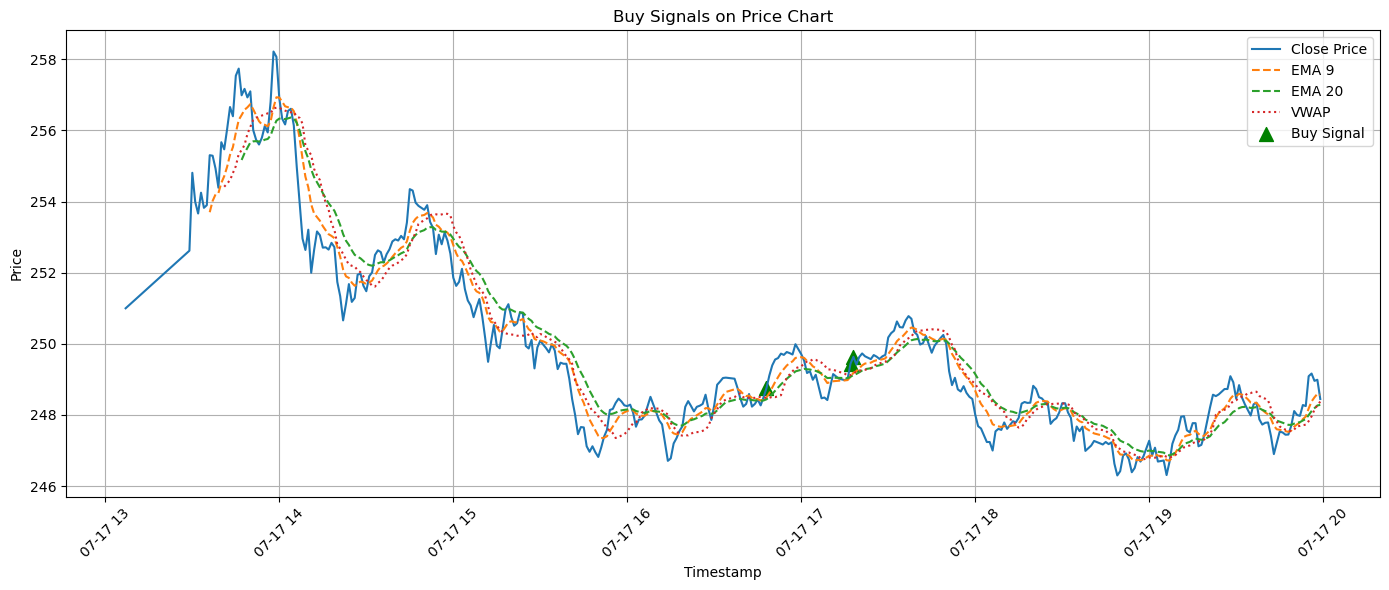

In [114]:
plot_buy_signals(df)

In [115]:
def backtest(df, stop_pct=0.01, target_pct=0.02, max_hold=20):
    results = []
    buy_indices = df[df['buy_signal']].index

    for i in buy_indices:
        entry_price = df.loc[i, 'close']
        stop_price = entry_price * (1 - stop_pct)
        target_price = entry_price * (1 + target_pct)
        outcome = "hold"

        for j in range(1, max_hold + 1):
            if i + j >= len(df):
                break
            price = df.loc[i + j, 'close']
            if price <= stop_price:
                outcome = "stop"
                break
            elif price >= target_price:
                outcome = "target"
                break

        results.append({
            "timestamp": df.loc[i, 'timestamp'],
            "entry": entry_price,
            "exit": price,
            "outcome": outcome
        })

    return pd.DataFrame(results)


In [116]:
bt_results = backtest(df)
print(bt_results)
print(bt_results['outcome'].value_counts())


                  timestamp    entry     exit outcome
0 2024-07-17 16:48:00+00:00  248.750  249.150    hold
1 2024-07-17 17:17:00+00:00  249.445  250.705    hold
2 2024-07-17 17:18:00+00:00  249.635  250.330    hold
outcome
hold    3
Name: count, dtype: int64


In [125]:
def analyze_ticker(ticker, start_date, end_date, feed="iex",
                   use_technical_exit=True, max_hold=60, rsi_thr=80, lag_window=3):
    # Step 1: Fetch data
    df = get_stock_data(ticker, start_date, end_date, feed=feed)
    if df.empty:
        print(f"\n🔍 Analyzing {ticker} — Pre-market top gainer on {start_date} …\n")
        print(f"{ticker} — plotting buy signals\n")
        print(f"No trades triggered for {ticker}.\n")
        return

    # Step 2: Add indicators
    df = add_indicators(df)

    # Step 3: Generate buy signals
    df['buy_signal'] = combined_signal_with_lag(df, window=lag_window)

    # Step 4: Plot signals
    print(f"\n🔍 Analyzing {ticker} — Pre-market top gainer on {start_date} …\n")
    print(f"{ticker} — plotting buy signals\n")
    plot_buy_signals(df)

    # Step 5: Backtest
    if use_technical_exit:
        bt = backtest_with_technical_exit(df, max_hold=max_hold)
    else:
        bt = backtest(df, stop_pct=0.01, target_pct=0.015, max_hold=max_hold)

    # Step 6: Results display
    if bt.empty:
        print(f"No trades triggered for {ticker}.\n")
        return

    print(f"{ticker} — Trades:")
    print(bt[['timestamp', 'entry', 'exit', 'outcome']])

    outcome_counts = bt['outcome'].value_counts()
    print("Outcome counts:\n", outcome_counts)

    win_count = (bt['outcome'] == 'exit').sum()
    total = len(bt)
    avg_return = (bt['exit'] / bt['entry'] - 1).mean()

    print(f"Win rate: {win_count}/{total} = {win_count/total:.2%}")
    print(f"Avg return per trade: {avg_return:.2%}\n")



🔍 Analyzing IEP — Pre-market top gainer on 2025-07-16 …

IEP — plotting buy signals



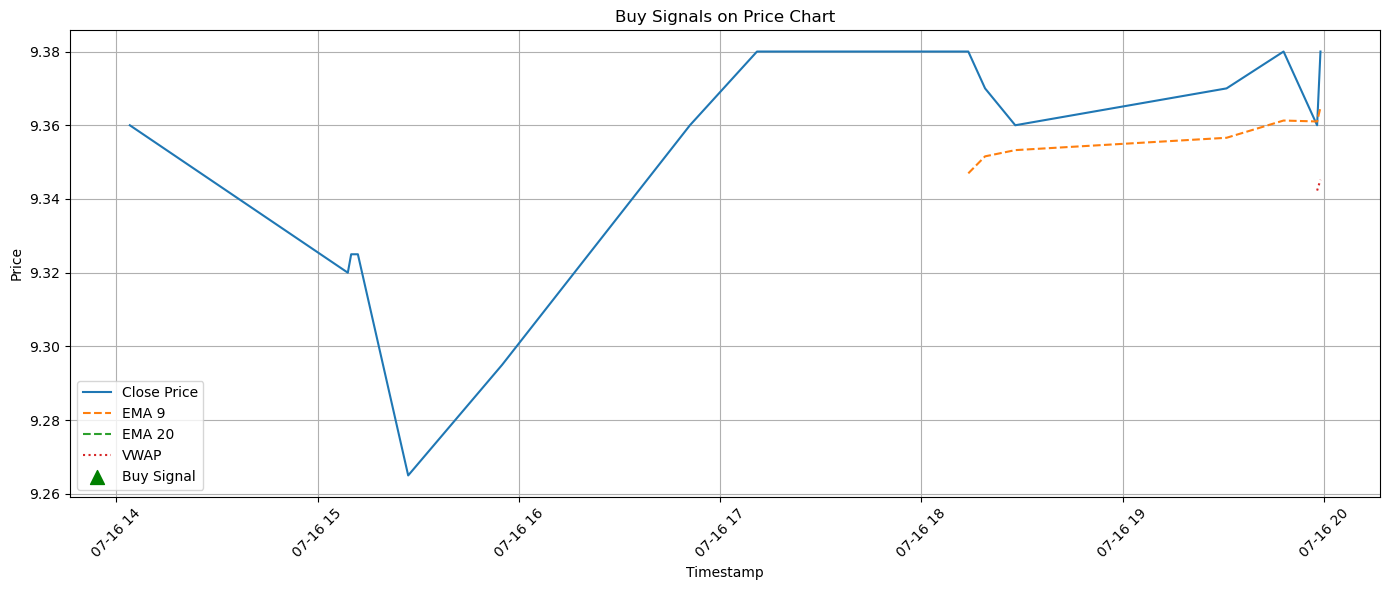

No trades triggered for IEP.


🔍 Analyzing U — Pre-market top gainer on 2025-07-16 …

U — plotting buy signals



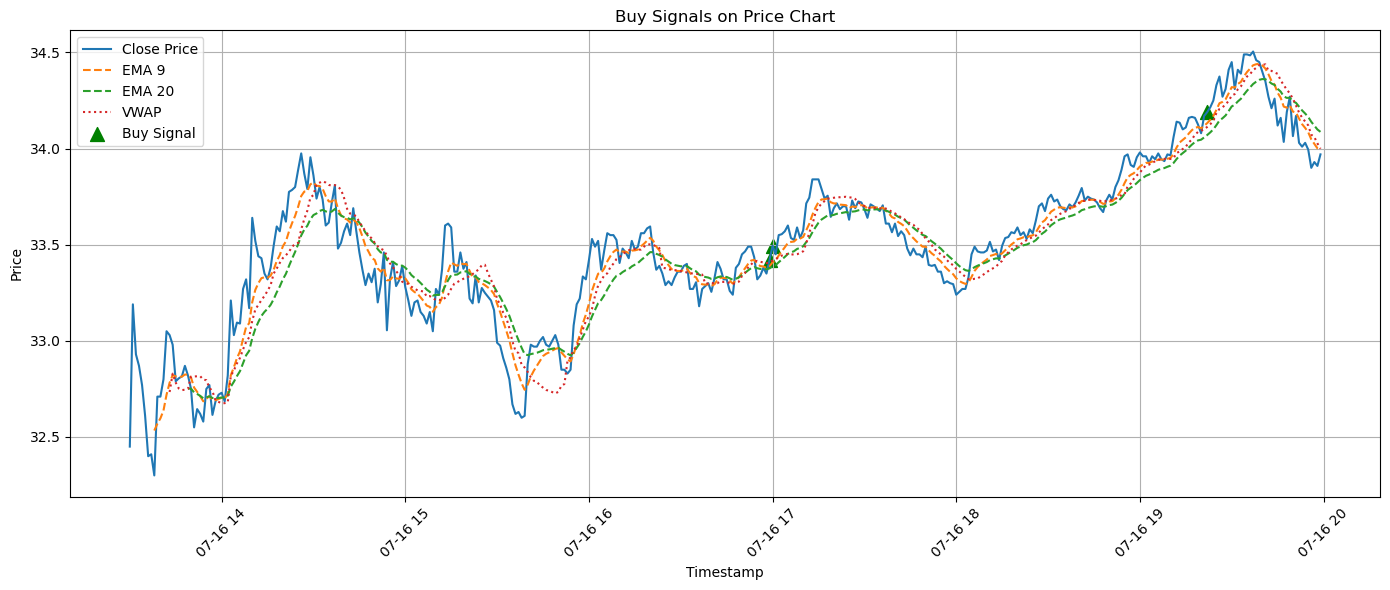

U — Trades:
                  timestamp   entry   exit outcome
0 2025-07-16 16:59:00+00:00  33.420  33.55    exit
1 2025-07-16 17:00:00+00:00  33.495  33.55    exit
2 2025-07-16 19:22:00+00:00  34.190  34.17    exit
Outcome counts:
 outcome
exit    3
Name: count, dtype: int64
Win rate: 3/3 = 100.00%
Avg return per trade: 0.16%


🔍 Analyzing GPN — Pre-market top gainer on 2025-07-16 …

GPN — plotting buy signals



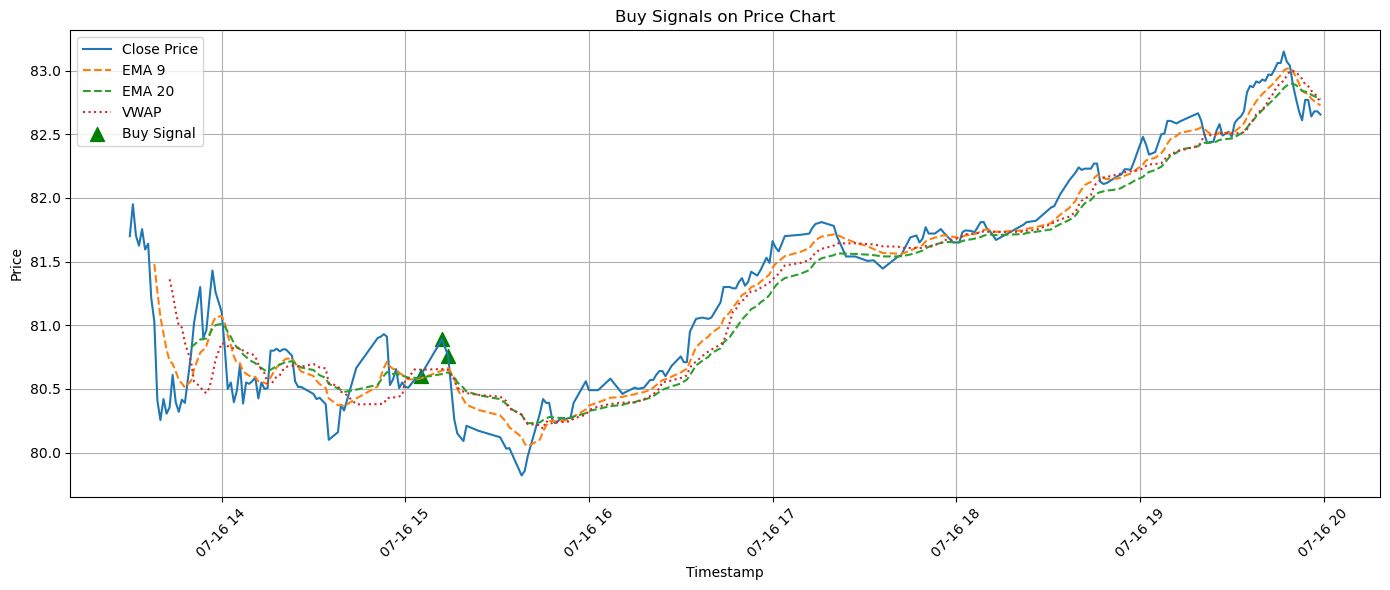

GPN — Trades:
                  timestamp   entry   exit outcome
0 2025-07-16 15:05:00+00:00  80.605  80.89    exit
1 2025-07-16 15:12:00+00:00  80.890  80.76    exit
2 2025-07-16 15:14:00+00:00  80.760  80.26    exit
Outcome counts:
 outcome
exit    3
Name: count, dtype: int64
Win rate: 3/3 = 100.00%
Avg return per trade: -0.14%


🔍 Analyzing RRR — Pre-market top gainer on 2025-07-16 …

RRR — plotting buy signals



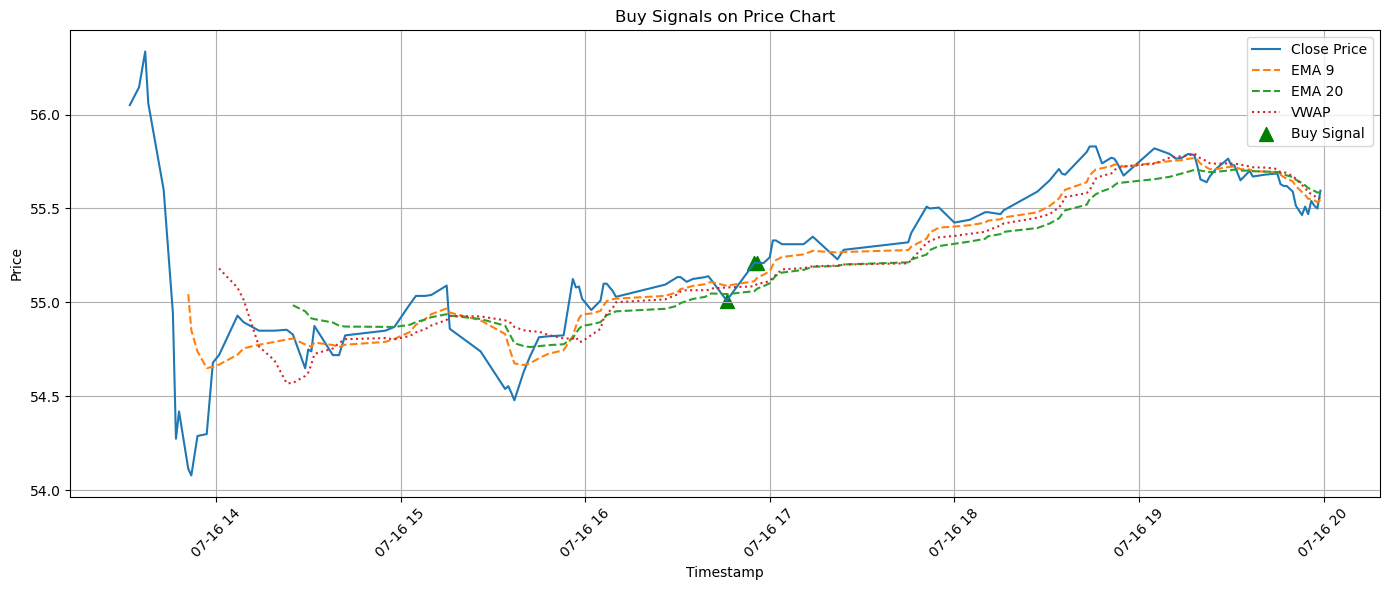

RRR — Trades:
                  timestamp  entry   exit outcome
0 2025-07-16 16:46:00+00:00  55.01  55.28    exit
1 2025-07-16 16:55:00+00:00  55.21  55.28    exit
2 2025-07-16 16:56:00+00:00  55.21  55.28    exit
Outcome counts:
 outcome
exit    3
Name: count, dtype: int64
Win rate: 3/3 = 100.00%
Avg return per trade: 0.25%


🔍 Analyzing FHN — Pre-market top gainer on 2025-07-16 …

FHN — plotting buy signals



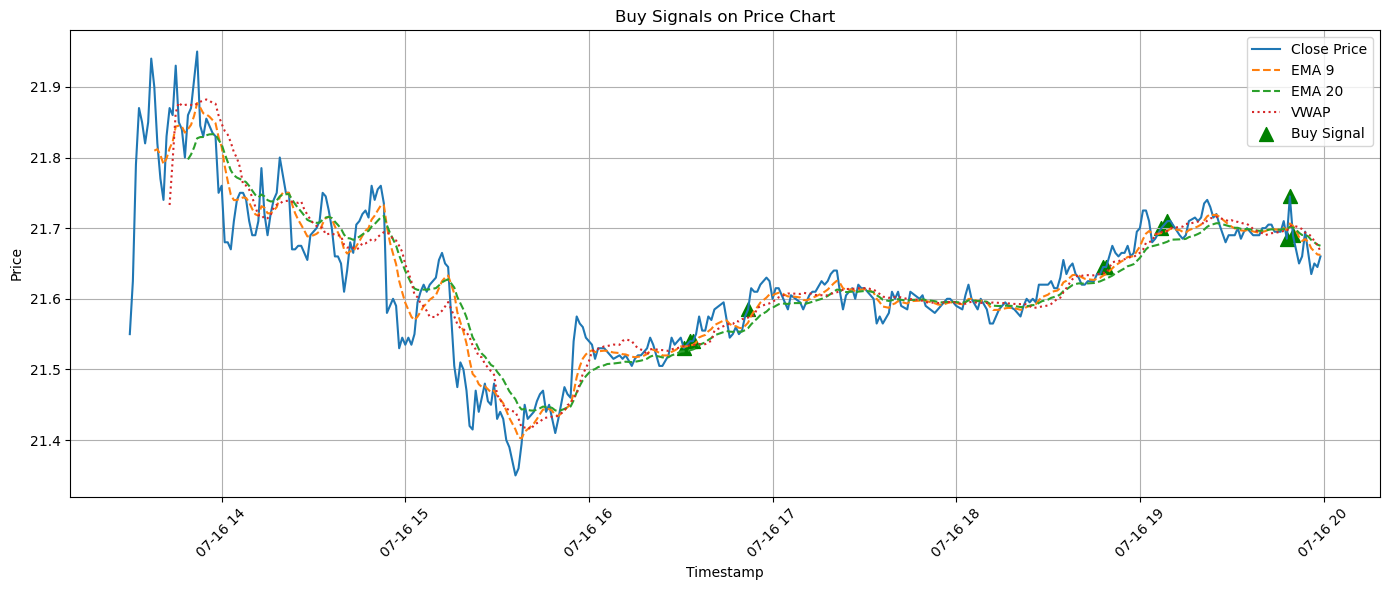

FHN — Trades:
                   timestamp   entry    exit outcome
0  2025-07-16 16:31:00+00:00  21.530  21.540    exit
1  2025-07-16 16:33:00+00:00  21.540  21.540    exit
2  2025-07-16 16:34:00+00:00  21.540  21.555    exit
3  2025-07-16 16:52:00+00:00  21.585  21.615    exit
4  2025-07-16 18:48:00+00:00  21.645  21.675    exit
5  2025-07-16 18:49:00+00:00  21.645  21.675    exit
6  2025-07-16 19:07:00+00:00  21.700  21.710    exit
7  2025-07-16 19:09:00+00:00  21.710  21.735    exit
8  2025-07-16 19:48:00+00:00  21.685  21.745    exit
9  2025-07-16 19:49:00+00:00  21.745  21.645    exit
10 2025-07-16 19:50:00+00:00  21.690  21.645    exit
Outcome counts:
 outcome
exit    11
Name: count, dtype: int64
Win rate: 11/11 = 100.00%
Avg return per trade: 0.03%



In [127]:
tickers = ["IEP", "U", "GPN", "RRR", "FHN"]
for t in tickers:
    analyze_ticker(
        ticker=t,
        start_date="2025-07-16",
        end_date="2025-07-17",
        use_technical_exit=True,  # now uses EMA/VWAP exit logic
        max_hold=60,
        rsi_thr=80,
        lag_window=3
    )



🔍 Analyzing TELO — Pre-market top gainer on 07/18/2025 …

 TELO — plotting buy signals


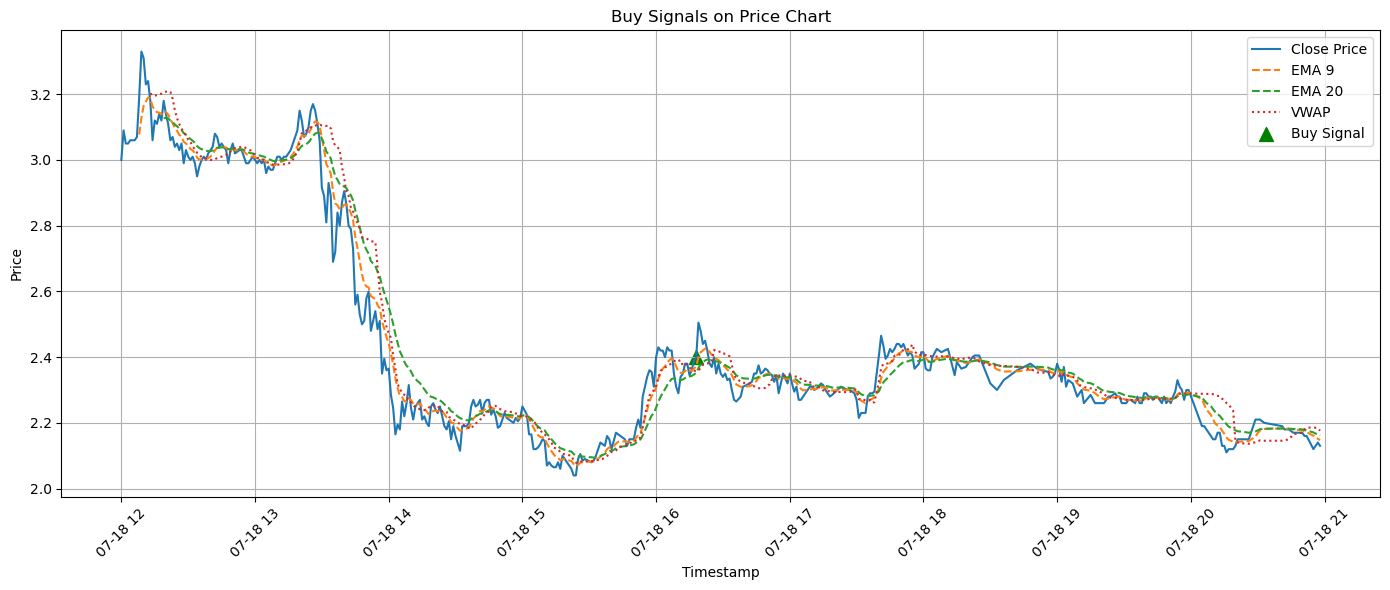

 TELO — Trades:
                   timestamp  entry   exit outcome
0 2025-07-18 16:18:00+00:00    2.4  2.505  target
Outcome counts: outcome
target    1
Name: count, dtype: int64
Win rate: 1/1 = 100.00%
Avg return per trade: 4.37%

🔍 Analyzing MEIP — Pre-market top gainer on 07/18/2025 …

 MEIP — plotting buy signals


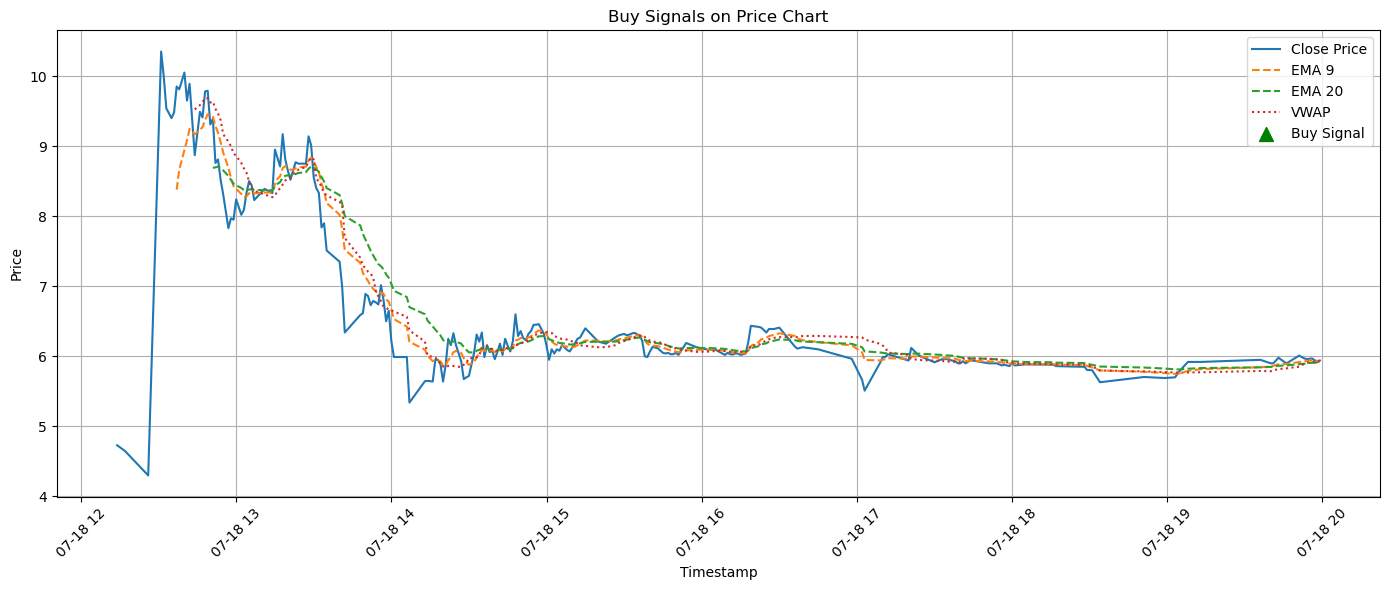

No trades triggered for MEIP.

🔍 Analyzing BZAI — Pre-market top gainer on 07/18/2025 …

 BZAI — plotting buy signals


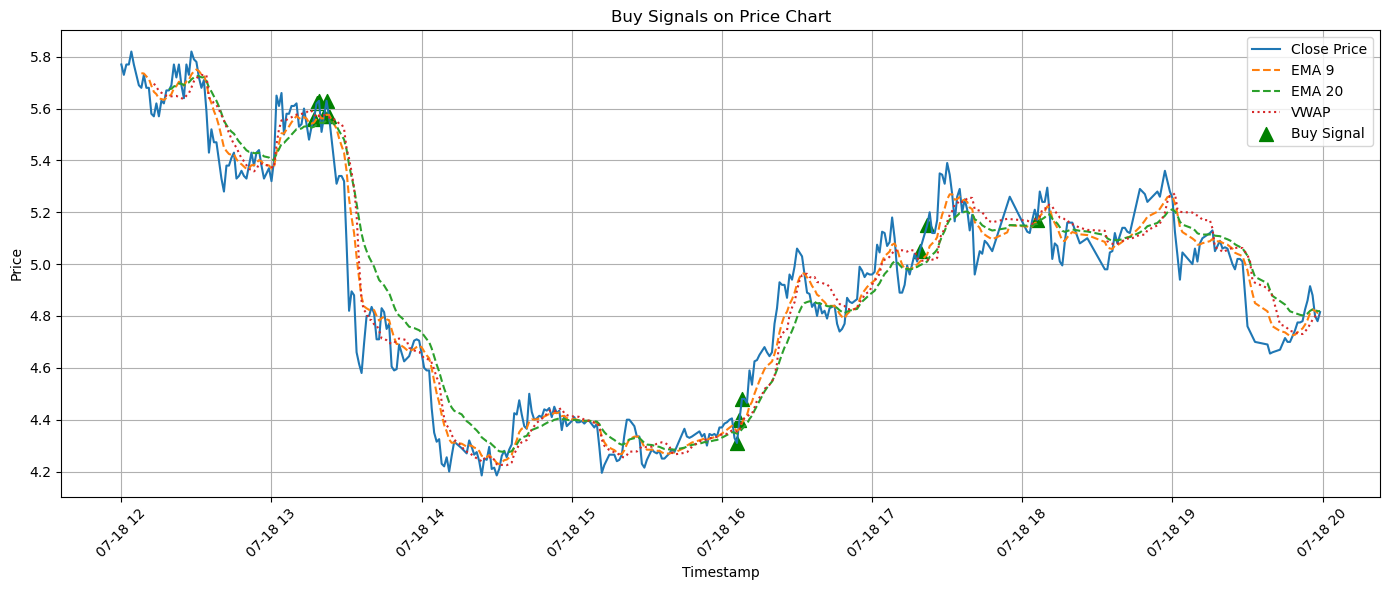

 BZAI — Trades:
                    timestamp  entry  exit outcome
0  2025-07-18 13:17:00+00:00   5.56  5.31    stop
1  2025-07-18 13:18:00+00:00   5.62  5.51    stop
2  2025-07-18 13:19:00+00:00   5.63  5.51    stop
3  2025-07-18 13:21:00+00:00   5.57  5.31    stop
4  2025-07-18 13:22:00+00:00   5.63  5.57    stop
5  2025-07-18 13:23:00+00:00   5.57  5.31    stop
6  2025-07-18 16:06:00+00:00   4.31  4.40  target
7  2025-07-18 16:07:00+00:00   4.40  4.48  target
8  2025-07-18 16:08:00+00:00   4.48  4.59  target
9  2025-07-18 17:19:00+00:00   5.05  5.15  target
10 2025-07-18 17:22:00+00:00   5.15  5.35  target
11 2025-07-18 18:06:00+00:00   5.17  5.28  target
Outcome counts: outcome
stop      6
target    6
Name: count, dtype: int64
Win rate: 6/12 = 50.00%
Avg return per trade: -0.39%

🔍 Analyzing CPOP — Pre-market top gainer on 07/18/2025 …

 CPOP — plotting buy signals


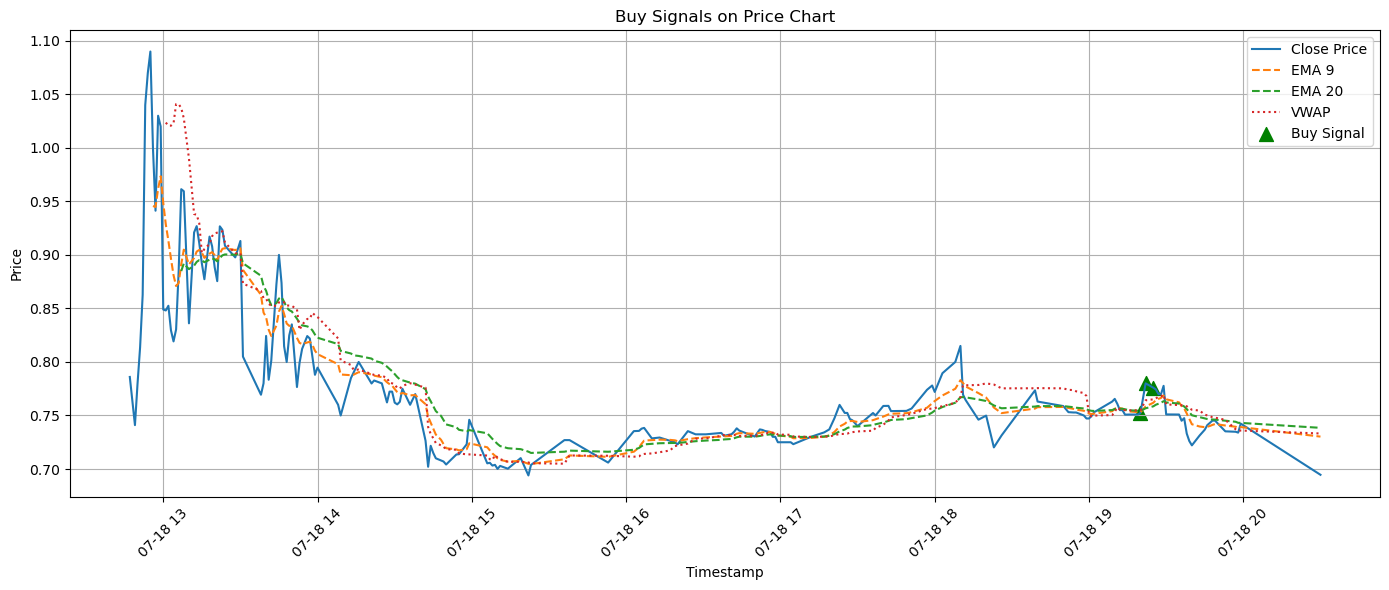

 CPOP — Trades:
                   timestamp   entry   exit outcome
0 2025-07-18 19:20:00+00:00  0.7523  0.780  target
1 2025-07-18 19:22:00+00:00  0.7800  0.770    stop
2 2025-07-18 19:25:00+00:00  0.7760  0.751    stop
Outcome counts: outcome
stop      2
target    1
Name: count, dtype: int64
Win rate: 1/3 = 33.33%
Avg return per trade: -0.27%

🔍 Analyzing UAVS — Pre-market top gainer on 07/18/2025 …

 UAVS — plotting buy signals


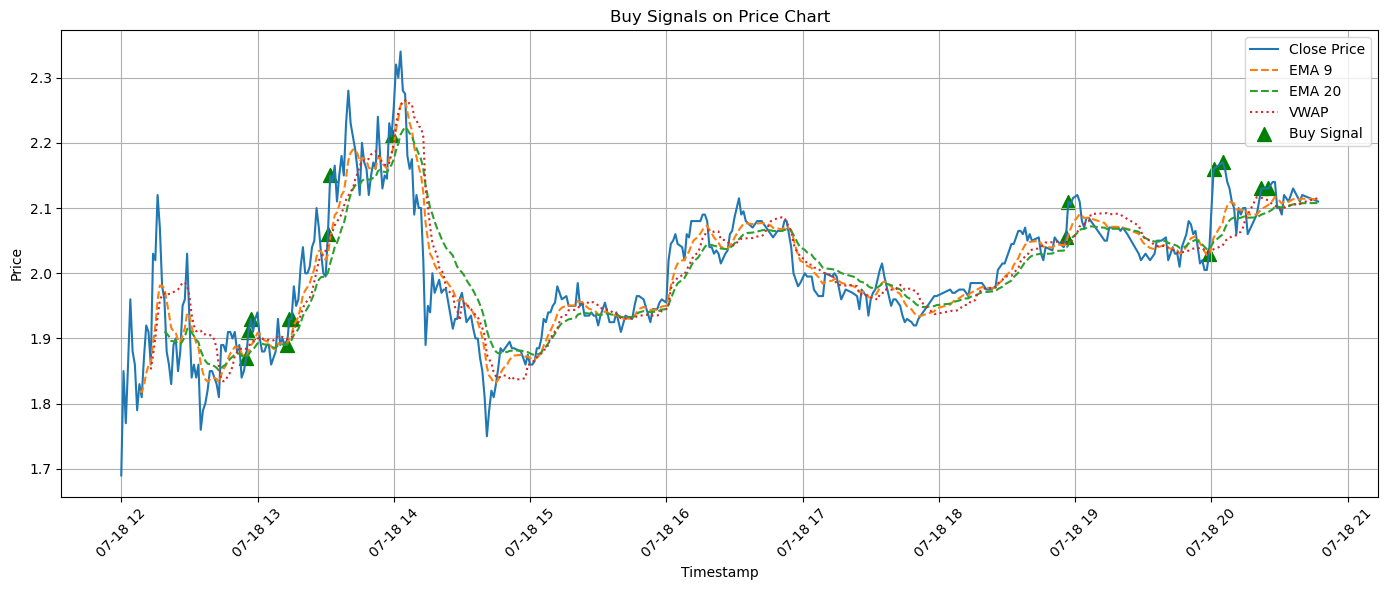

 UAVS — Trades:
                    timestamp  entry   exit outcome
0  2025-07-18 12:55:00+00:00  1.870  1.910  target
1  2025-07-18 12:56:00+00:00  1.910  1.940  target
2  2025-07-18 12:57:00+00:00  1.930  1.910    stop
3  2025-07-18 13:13:00+00:00  1.890  1.930  target
4  2025-07-18 13:14:00+00:00  1.930  1.980  target
5  2025-07-18 13:15:00+00:00  1.930  1.980  target
6  2025-07-18 13:31:00+00:00  2.060  2.150  target
7  2025-07-18 13:32:00+00:00  2.150  2.110    stop
8  2025-07-18 13:59:00+00:00  2.210  2.255  target
9  2025-07-18 18:56:00+00:00  2.055  2.110  target
10 2025-07-18 18:57:00+00:00  2.110  2.080    stop
11 2025-07-18 19:59:00+00:00  2.030  2.160  target
12 2025-07-18 20:01:00+00:00  2.160  2.130    stop
13 2025-07-18 20:05:00+00:00  2.170  2.140    stop
14 2025-07-18 20:22:00+00:00  2.130  2.100    stop
15 2025-07-18 20:25:00+00:00  2.130  2.100    stop
Outcome counts: outcome
target    9
stop      7
Name: count, dtype: int64
Win rate: 9/16 = 56.25%
Avg return per tra

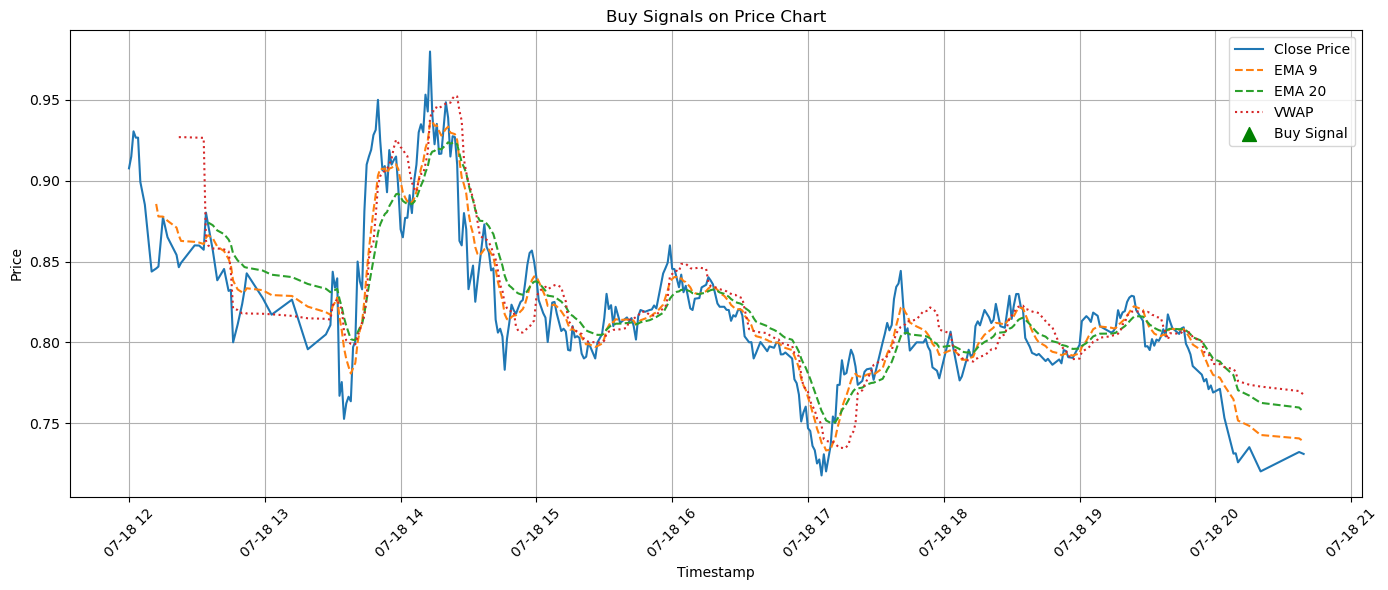

No trades triggered for BTOG.

🔍 Analyzing XPON — Pre-market top gainer on 07/18/2025 …

 XPON — plotting buy signals


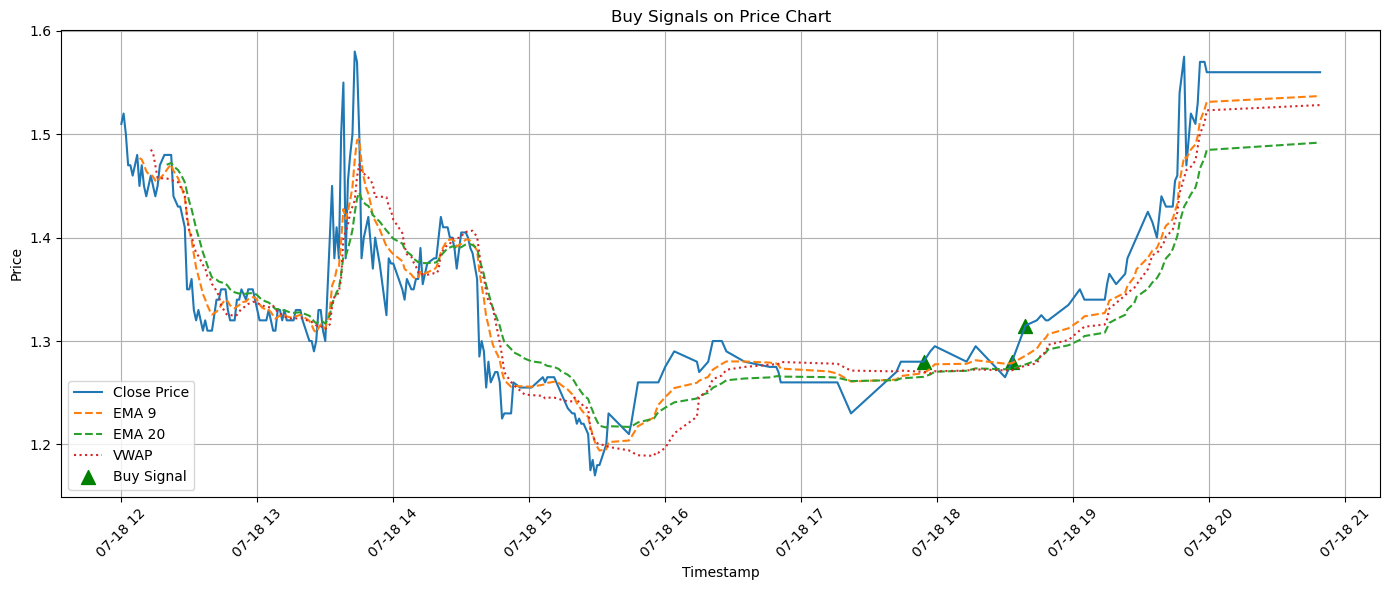

 XPON — Trades:
                   timestamp  entry   exit outcome
0 2025-07-18 17:54:00+00:00  1.280  1.265    stop
1 2025-07-18 18:33:00+00:00  1.280  1.315  target
2 2025-07-18 18:39:00+00:00  1.315  1.335  target
Outcome counts: outcome
target    2
stop      1
Name: count, dtype: int64
Win rate: 2/3 = 66.67%
Avg return per trade: 1.03%

🔍 Analyzing ATHA — Pre-market top gainer on 07/18/2025 …

 ATHA — plotting buy signals


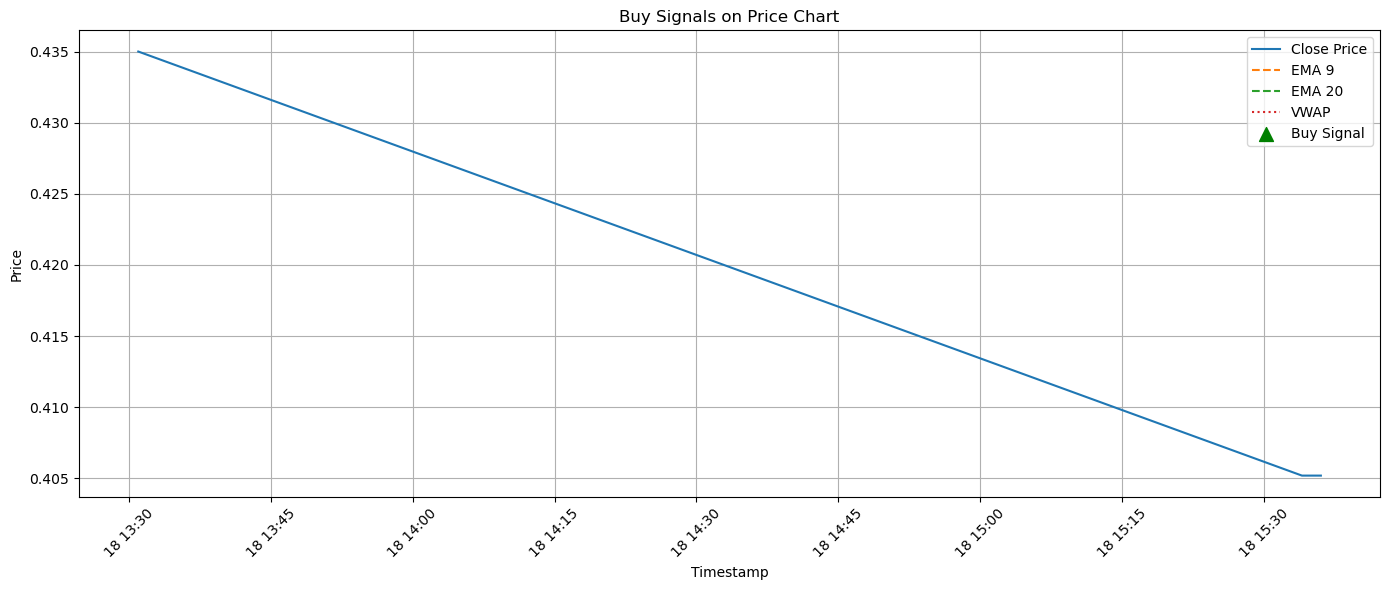

No trades triggered for ATHA.

🔍 Analyzing MESO — Pre-market top gainer on 07/18/2025 …

 MESO — plotting buy signals


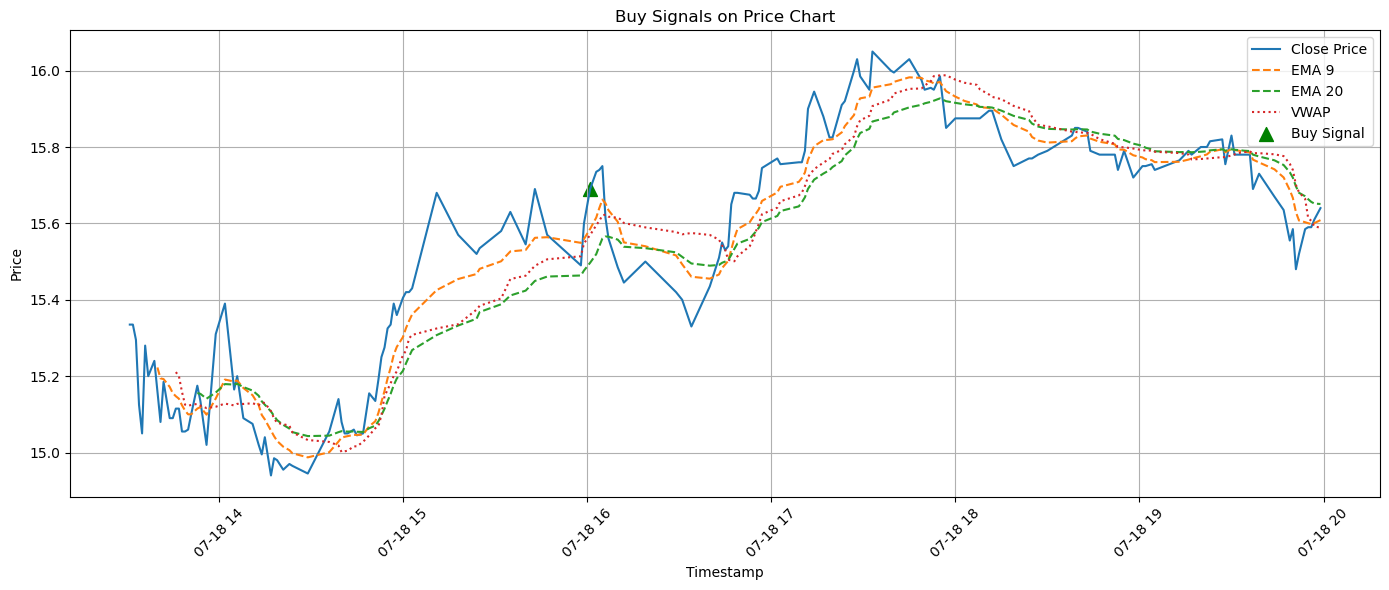

 MESO — Trades:
                   timestamp  entry    exit outcome
0 2025-07-18 16:01:00+00:00  15.69  15.485    stop
Outcome counts: outcome
stop    1
Name: count, dtype: int64
Win rate: 0/1 = 0.00%
Avg return per trade: -1.31%

🔍 Analyzing SVRE — Pre-market top gainer on 07/18/2025 …

 SVRE — plotting buy signals


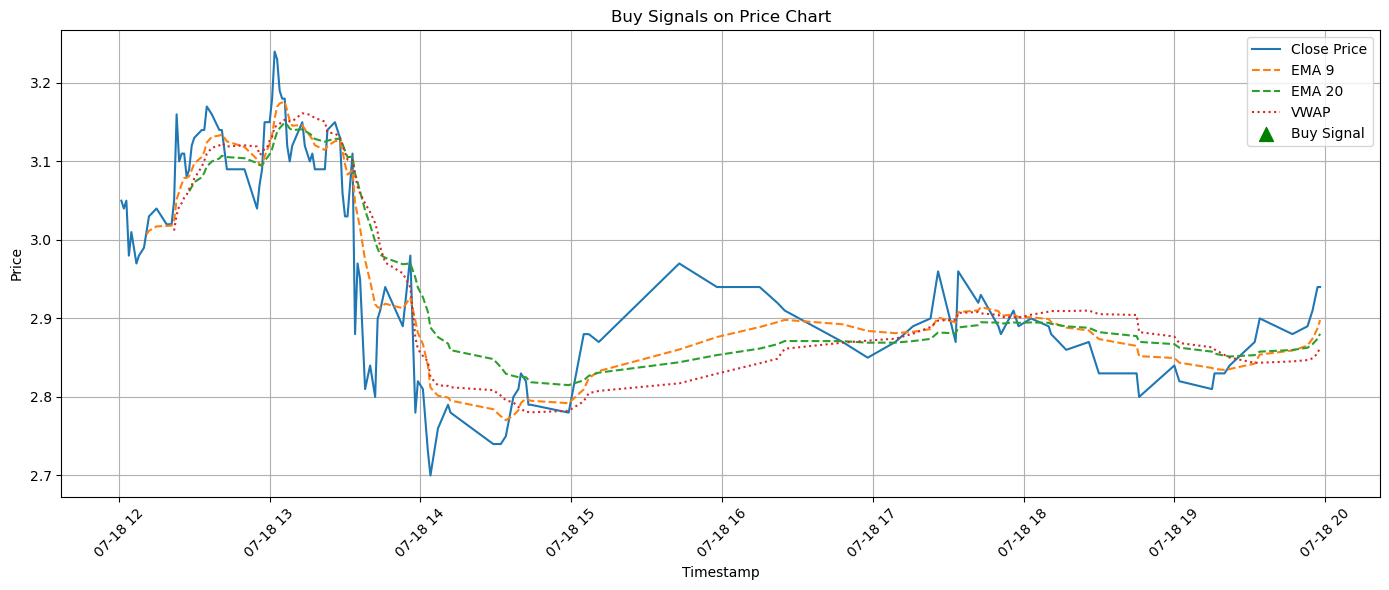

No trades triggered for SVRE.


In [119]:
tickers = ["TELO", "MEIP", "BZAI", "CPOP", "UAVS", "BTOG", "XPON", "ATHA", "MESO", "SVRE"]

for t in tickers:
    print(f"\n🔍 Analyzing {t} — Pre-market top gainer on 07/18/2025 …")
    analyze_ticker(
        ticker=t,
        start_date="2025-07-18",  # match the gainer date
        end_date="2025-07-19",
        feed="iex",
        stop_pct=0.01,
        target_pct=0.015,
        max_hold=60,
        rsi_thr=80,
        lag_window=3
    )


In [120]:
def backtest_with_technical_exit(df, max_hold=60):
    """
    Backtest using technical exit conditions instead of price-based stop/target.

    Entry: when buy_signal is True  
    Exit:  
        - EMA20 crosses below EMA9  
        - OR VWAP crosses below EMA9 or EMA20 (whichever comes first)

    Returns:
        pd.DataFrame with timestamp, entry, exit, outcome, and duration.
    """
    results = []
    buy_indices = df[df['buy_signal']].index

    for i in buy_indices:
        entry_time = df.loc[i, 'timestamp']
        entry_price = df.loc[i, 'close']
        exit_price = entry_price  # fallback in case no exit
        outcome = "hold"
        exit_time = entry_time

        for j in range(i + 1, min(i + max_hold + 1, len(df))):
            prev_row = df.loc[j - 1]
            curr_row = df.loc[j]

            # Check for EMA20 crossing below EMA9
            ema_cross = (
                prev_row['ema_20'] >= prev_row['ema_9'] and
                curr_row['ema_20'] < curr_row['ema_9']
            )

            # VWAP crossing below EMA9 or EMA20 (whichever is first)
            vwap_cross_9 = (
                prev_row['vwap'] >= prev_row['ema_9'] and
                curr_row['vwap'] < curr_row['ema_9']
            )
            vwap_cross_20 = (
                prev_row['vwap'] >= prev_row['ema_20'] and
                curr_row['vwap'] < curr_row['ema_20']
            )

            if ema_cross or vwap_cross_9 or vwap_cross_20:
                exit_price = curr_row['close']
                exit_time = curr_row['timestamp']
                outcome = "exit"
                break

        results.append({
            "timestamp": entry_time,
            "entry": entry_price,
            "exit": exit_price,
            "exit_time": exit_time,
            "outcome": outcome,
            "duration": (exit_time - entry_time).total_seconds() / 60  # minutes
        })

    return pd.DataFrame(results)


In [121]:
bt = backtest_with_technical_exit(df, max_hold=60)

In [122]:
if not bt.empty:
    avg_return = (bt['exit'] / bt['entry'] - 1).mean()
    print(f"Avg return per trade: {avg_return:.2%}")
    print(f"Trades exited: {bt['outcome'].value_counts().to_dict()}")


Avg return per trade: 0.08%
Trades exited: {'exit': 3}


In [128]:
def backtest_smart_exit(df, max_hold=60, pullback_pct=0.005):
    """
    Backtest strategy with advanced dynamic exits:
    - Entry: buy_signal
    - Exit: max drawdown from peak, EMA9 trend loss, MACD flip, or time limit
    """
    results = []
    buy_indices = df[df['buy_signal']].index

    for i in buy_indices:
        entry_price = df.loc[i, 'close']
        entry_time = df.loc[i, 'timestamp']
        max_price = entry_price
        exit_price = entry_price
        outcome = "hold"
        exit_time = entry_time

        for j in range(i + 1, min(i + max_hold + 1, len(df))):
            row = df.loc[j]
            prev_row = df.loc[j - 1]
            price = row['close']
            max_price = max(max_price, price)

            # 1. Pullback from peak
            if price < max_price * (1 - pullback_pct):
                outcome = "pullback_exit"
                exit_price = price
                exit_time = row['timestamp']
                break

            # 2. EMA9 slope reversal
            if df.loc[j, 'ema_9'] - df.loc[j - 1, 'ema_9'] < 0:
                outcome = "ema9_turn"
                exit_price = price
                exit_time = row['timestamp']
                break

            # 3. MACD histogram flip
            if row['macd_diff'] < 0 and prev_row['macd_diff'] >= 0:
                outcome = "macd_flip"
                exit_price = price
                exit_time = row['timestamp']
                break

        # 4. Failsafe time exit
        if outcome == "hold":
            outcome = "timeout"
            exit_price = df.loc[min(i + max_hold, len(df) - 1), 'close']
            exit_time = df.loc[min(i + max_hold, len(df) - 1), 'timestamp']

        results.append({
            "timestamp": entry_time,
            "entry": entry_price,
            "exit": exit_price,
            "exit_time": exit_time,
            "outcome": outcome,
            "return_pct": (exit_price / entry_price - 1) * 100
        })

    return pd.DataFrame(results)


In [129]:
bt = backtest_smart_exit(df, max_hold=60, pullback_pct=0.006)  # e.g. 0.6% drawdown exit

In [130]:
def analyze_ticker_smart(ticker, start_date, end_date, feed="iex",
                         max_hold=60, rsi_thr=80, lag_window=3, pullback_pct=0.006):
    print(f"\n🔍 Analyzing {ticker} — Pre-market top gainer on {start_date} …\n")

    df = get_stock_data(ticker, start_date, end_date, feed=feed)
    if df.empty:
        print(f"{ticker} — plotting buy signals\n")
        print(f"No trades triggered for {ticker}.\n")
        return

    df = add_indicators(df)
    df['buy_signal'] = combined_signal_with_lag(df, window=lag_window)

    print(f"{ticker} — plotting buy signals\n")
    plot_buy_signals(df)

    bt = backtest_smart_exit(df, max_hold=max_hold, pullback_pct=pullback_pct)

    if bt.empty:
        print(f"No trades triggered for {ticker}.\n")
        return

    print(f"{ticker} — Trades:")
    print(bt[['timestamp', 'entry', 'exit', 'outcome']])

    outcome_counts = bt['outcome'].value_counts()
    print("Outcome counts:\n", outcome_counts)

    wins = sum(bt['return_pct'] > 0)
    total = len(bt)
    avg_return = bt['return_pct'].mean()

    print(f"Win rate: {wins}/{total} = {wins/total:.2%}")
    print(f"Avg return per trade: {avg_return:.2f}%\n")



🔍 Analyzing TELO — Pre-market top gainer on 2025-07-18 …

TELO — plotting buy signals



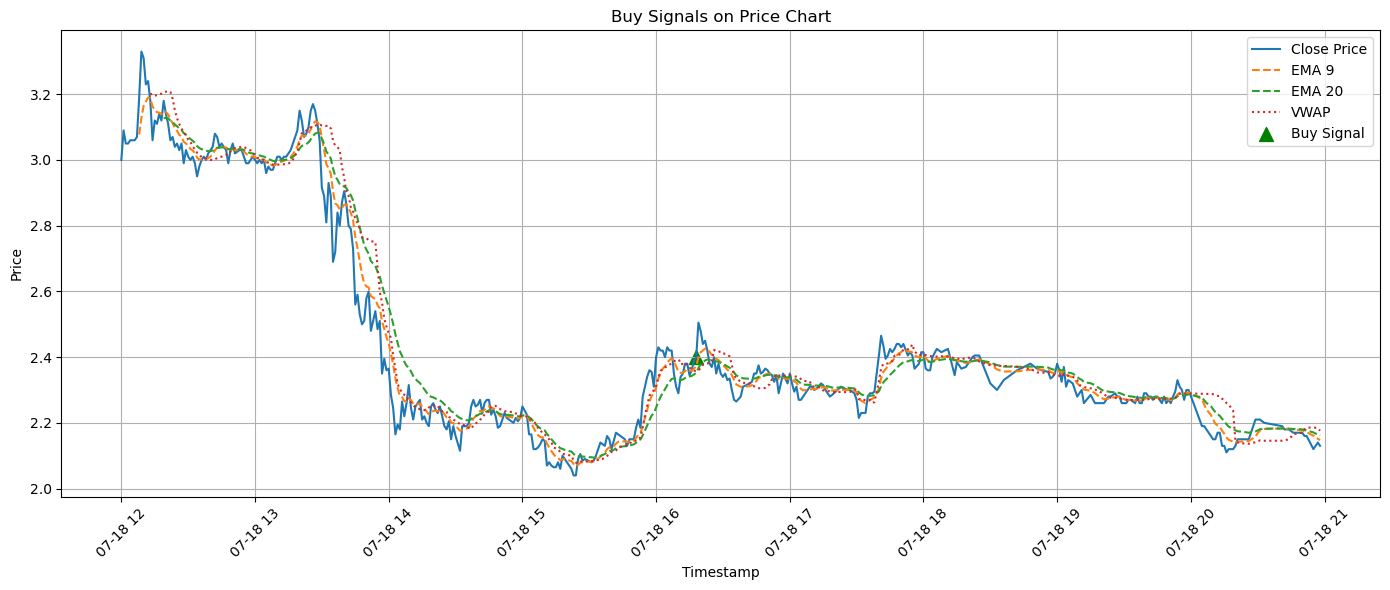

TELO — Trades:
                  timestamp  entry  exit        outcome
0 2025-07-18 16:18:00+00:00    2.4  2.48  pullback_exit
Outcome counts:
 outcome
pullback_exit    1
Name: count, dtype: int64
Win rate: 1/1 = 100.00%
Avg return per trade: 3.33%


🔍 Analyzing MEIP — Pre-market top gainer on 2025-07-18 …

MEIP — plotting buy signals



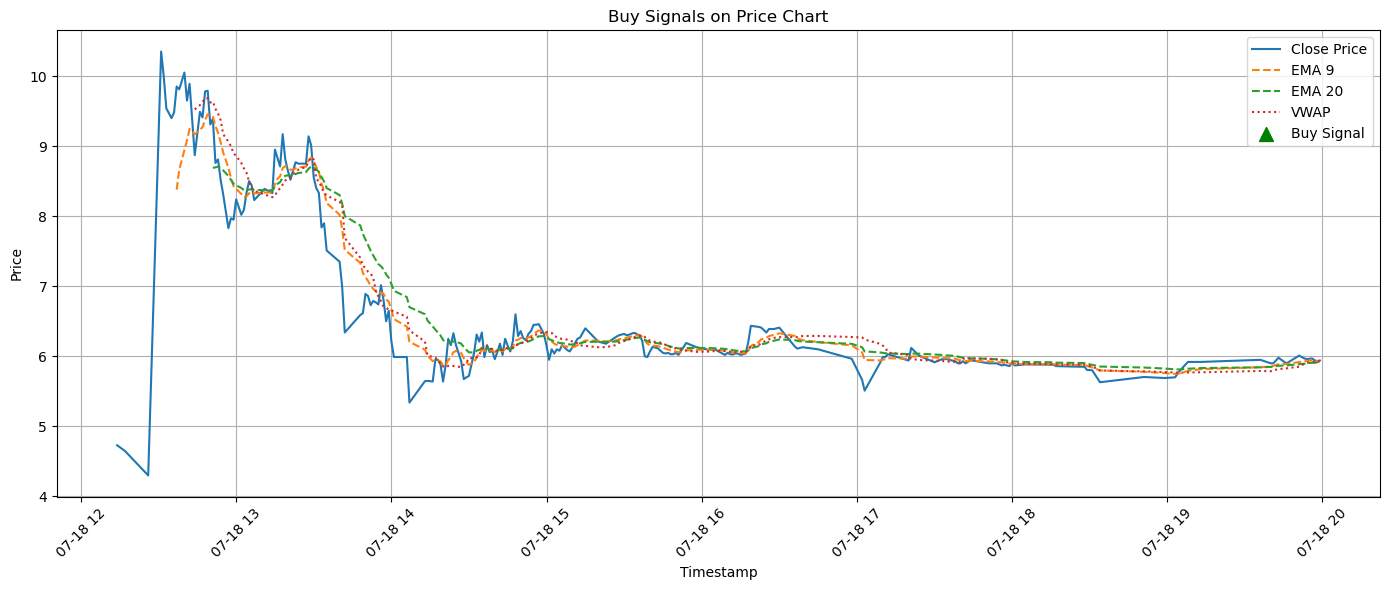

No trades triggered for MEIP.


🔍 Analyzing BZAI — Pre-market top gainer on 2025-07-18 …

BZAI — plotting buy signals



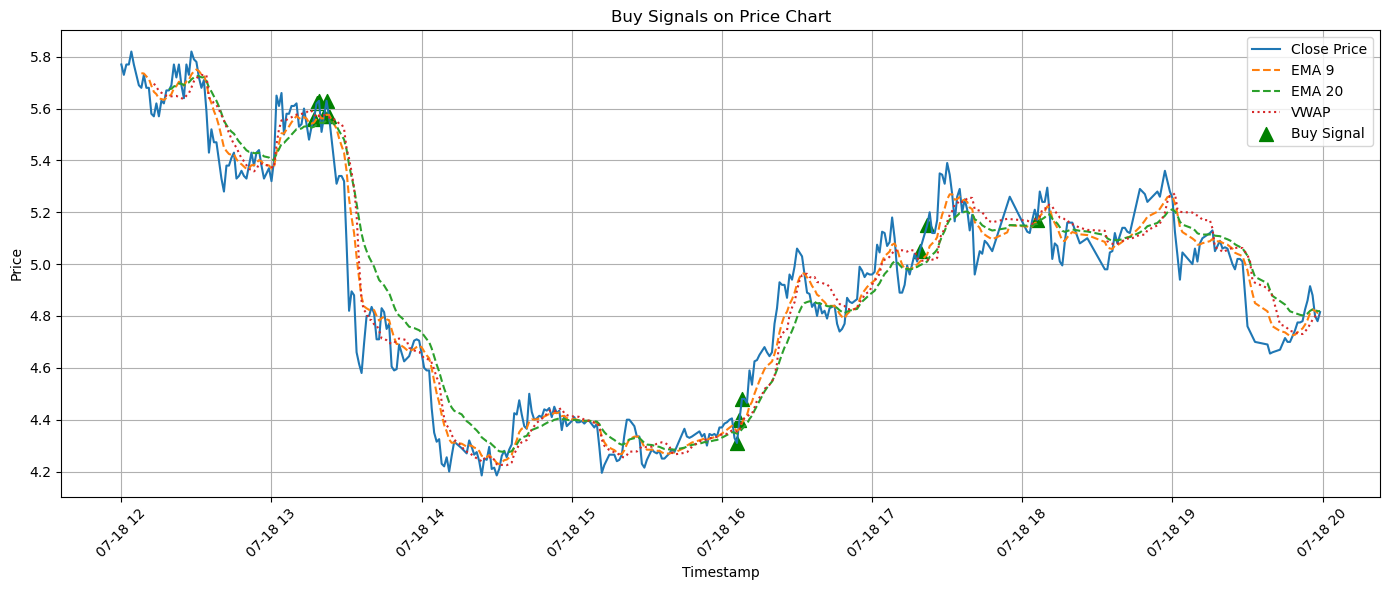

BZAI — Trades:
                   timestamp  entry   exit        outcome
0  2025-07-18 13:17:00+00:00   5.56  5.510  pullback_exit
1  2025-07-18 13:18:00+00:00   5.62  5.510  pullback_exit
2  2025-07-18 13:19:00+00:00   5.63  5.510  pullback_exit
3  2025-07-18 13:21:00+00:00   5.57  5.570  pullback_exit
4  2025-07-18 13:22:00+00:00   5.63  5.570  pullback_exit
5  2025-07-18 13:23:00+00:00   5.57  5.310  pullback_exit
6  2025-07-18 16:06:00+00:00   4.31  4.535  pullback_exit
7  2025-07-18 16:07:00+00:00   4.40  4.535  pullback_exit
8  2025-07-18 16:08:00+00:00   4.48  4.535  pullback_exit
9  2025-07-18 17:19:00+00:00   5.05  5.120  pullback_exit
10 2025-07-18 17:22:00+00:00   5.15  5.120  pullback_exit
11 2025-07-18 18:06:00+00:00   5.17  5.240  pullback_exit
Outcome counts:
 outcome
pullback_exit    12
Name: count, dtype: int64
Win rate: 5/12 = 41.67%
Avg return per trade: 0.08%


🔍 Analyzing CPOP — Pre-market top gainer on 2025-07-18 …

CPOP — plotting buy signals



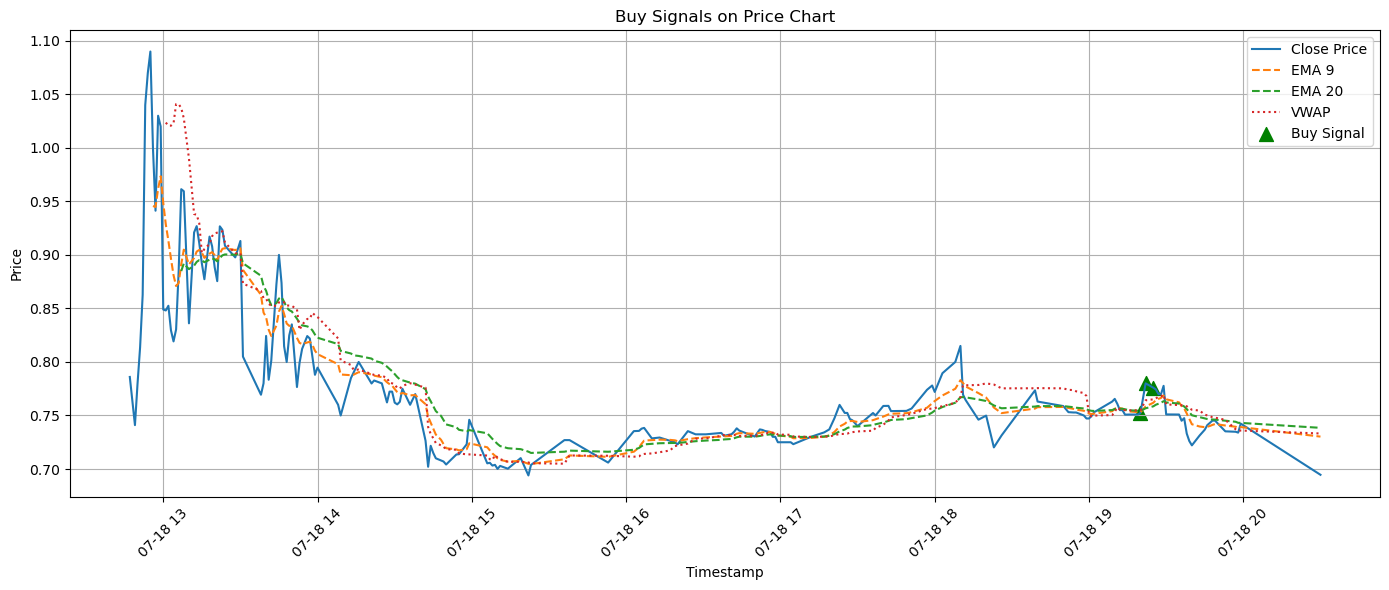

CPOP — Trades:
                  timestamp   entry    exit        outcome
0 2025-07-18 19:20:00+00:00  0.7523  0.7743  pullback_exit
1 2025-07-18 19:22:00+00:00  0.7800  0.7743  pullback_exit
2 2025-07-18 19:25:00+00:00  0.7760  0.7700  pullback_exit
Outcome counts:
 outcome
pullback_exit    3
Name: count, dtype: int64
Win rate: 1/3 = 33.33%
Avg return per trade: 0.47%


🔍 Analyzing UAVS — Pre-market top gainer on 2025-07-18 …

UAVS — plotting buy signals



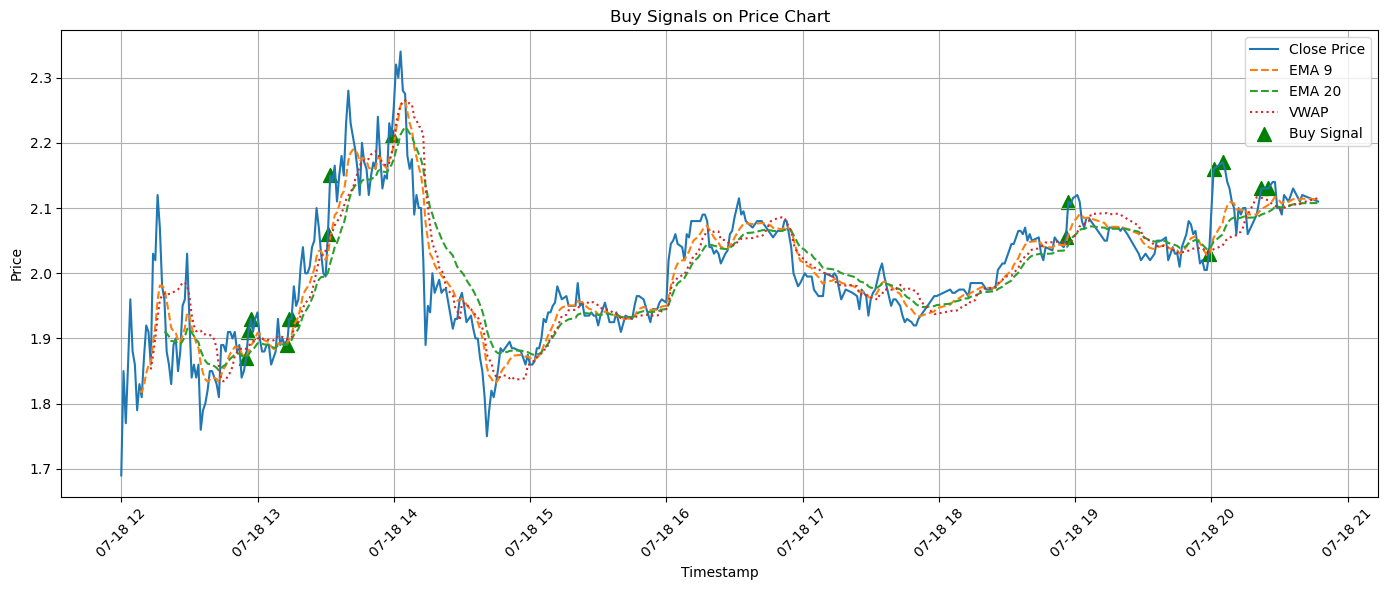

UAVS — Trades:
                   timestamp  entry  exit        outcome
0  2025-07-18 12:55:00+00:00  1.870  1.91  pullback_exit
1  2025-07-18 12:56:00+00:00  1.910  1.91  pullback_exit
2  2025-07-18 12:57:00+00:00  1.930  1.91  pullback_exit
3  2025-07-18 13:13:00+00:00  1.890  1.95  pullback_exit
4  2025-07-18 13:14:00+00:00  1.930  1.95  pullback_exit
5  2025-07-18 13:15:00+00:00  1.930  1.95  pullback_exit
6  2025-07-18 13:31:00+00:00  2.060  2.11  pullback_exit
7  2025-07-18 13:32:00+00:00  2.150  2.11  pullback_exit
8  2025-07-18 13:59:00+00:00  2.210  2.30  pullback_exit
9  2025-07-18 18:56:00+00:00  2.055  2.08  pullback_exit
10 2025-07-18 18:57:00+00:00  2.110  2.08  pullback_exit
11 2025-07-18 19:59:00+00:00  2.030  2.14  pullback_exit
12 2025-07-18 20:01:00+00:00  2.160  2.14  pullback_exit
13 2025-07-18 20:05:00+00:00  2.170  2.14  pullback_exit
14 2025-07-18 20:22:00+00:00  2.130  2.10  pullback_exit
15 2025-07-18 20:25:00+00:00  2.130  2.10  pullback_exit
Outcome counts:


In [131]:
tickers = ["TELO", "MEIP", "BZAI", "CPOP", "UAVS"]

for t in tickers:
    analyze_ticker_smart(
        ticker=t,
        start_date="2025-07-18",
        end_date="2025-07-19",
        max_hold=60,
        rsi_thr=80,
        lag_window=3,
        pullback_pct=0.006  # 0.6% from peak
    )


In [132]:
def plot_signals_with_exits(df, trades_df=None):
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df['close'], label='Close Price', linewidth=1.5)
    plt.plot(df['timestamp'], df['ema_9'], label='EMA 9', linestyle='--')
    plt.plot(df['timestamp'], df['ema_20'], label='EMA 20', linestyle='--')
    plt.plot(df['timestamp'], df['vwap'], label='VWAP', linestyle=':')

    # Buy markers
    buys = df[df['buy_signal']]
    plt.scatter(buys['timestamp'], buys['close'], color='green', label='Buy Signal', marker='^', s=100)

    # Exit markers (optional)
    if trades_df is not None:
        for _, row in trades_df.iterrows():
            plt.scatter(row['exit_time'], row['exit'], color='red', marker='v', s=80, label='Exit Signal')

    # Avoid duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Buy & Exit Signals on Price Chart')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [133]:
def backtest_smart_plus(df, max_hold=60, pullback_pct=0.006, min_gain_before_exit=0.005):
    results = []
    buy_indices = df[df['buy_signal']].index

    for i in buy_indices:
        entry_price = df.loc[i, 'close']
        entry_time = df.loc[i, 'timestamp']
        max_price = entry_price
        exit_price = entry_price
        exit_time = entry_time
        outcome = "hold"

        for j in range(i + 1, min(i + max_hold + 1, len(df))):
            row = df.loc[j]
            prev_row = df.loc[j - 1]
            price = row['close']
            max_price = max(max_price, price)
            gain = (price / entry_price) - 1

            # 1. Pullback after gain
            if gain > min_gain_before_exit and price < max_price * (1 - pullback_pct):
                outcome = "pullback_after_gain"
                exit_price = price
                exit_time = row['timestamp']
                break

            # 2. EMA9 peak & dip
            ema9_slope = df.loc[j, 'ema_9'] - df.loc[j - 1, 'ema_9']
            prev_ema9_slope = df.loc[j - 1, 'ema_9'] - df.loc[j - 2, 'ema_9'] if j > i + 1 else 0
            if prev_ema9_slope > 0 and ema9_slope < 0:
                outcome = "ema9_peak"
                exit_price = price
                exit_time = row['timestamp']
                break

            # 3. MACD histogram flip (only if it was up before)
            if prev_row['macd_diff'] > 0 and row['macd_diff'] < 0:
                outcome = "macd_flip_down"
                exit_price = price
                exit_time = row['timestamp']
                break

            # 4. VWAP + EMA9 crossover (trend collapse)
            if price < row['vwap'] and price < row['ema_9']:
                outcome = "trend_break"
                exit_price = price
                exit_time = row['timestamp']
                break

        if outcome == "hold":
            outcome = "timeout"
            exit_price = df.loc[min(i + max_hold, len(df) - 1), 'close']
            exit_time = df.loc[min(i + max_hold, len(df) - 1), 'timestamp']

        results.append({
            "timestamp": entry_time,
            "entry": entry_price,
            "exit": exit_price,
            "exit_time": exit_time,
            "outcome": outcome,
            "return_pct": (exit_price / entry_price - 1) * 100
        })

    return pd.DataFrame(results)


In [134]:
def analyze_ticker_smart_plus(ticker, start_date, end_date, feed="iex",
                              max_hold=60, rsi_thr=80, lag_window=3,
                              pullback_pct=0.006, min_gain_before_exit=0.005):
    print(f"\n🔍 Analyzing {ticker} — Pre-market top gainer on {start_date} …\n")

    df = get_stock_data(ticker, start_date, end_date, feed=feed)
    if df.empty:
        print(f"{ticker} — plotting buy signals\n")
        print(f"No trades triggered for {ticker}.\n")
        return

    df = add_indicators(df)
    df['buy_signal'] = combined_signal_with_lag(df, window=lag_window)

    bt = backtest_smart_plus(df, max_hold=max_hold,
                             pullback_pct=pullback_pct,
                             min_gain_before_exit=min_gain_before_exit)

    print(f"{ticker} — plotting buy & exit signals\n")
    plot_signals_with_exits(df, trades_df=bt)

    if bt.empty:
        print(f"No trades triggered for {ticker}.\n")
        return

    print(f"{ticker} — Trades:")
    print(bt[['timestamp', 'entry', 'exit', 'outcome']])

    outcome_counts = bt['outcome'].value_counts()
    print("Outcome counts:\n", outcome_counts)

    wins = (bt['return_pct'] > 0).sum()
    total = len(bt)
    avg_return = bt['return_pct'].mean()

    print(f"Win rate: {wins}/{total} = {wins/total:.2%}")
    print(f"Avg return per trade: {avg_return:.2f}%\n")



🔍 Analyzing BZAI — Pre-market top gainer on 2025-07-18 …

BZAI — plotting buy & exit signals



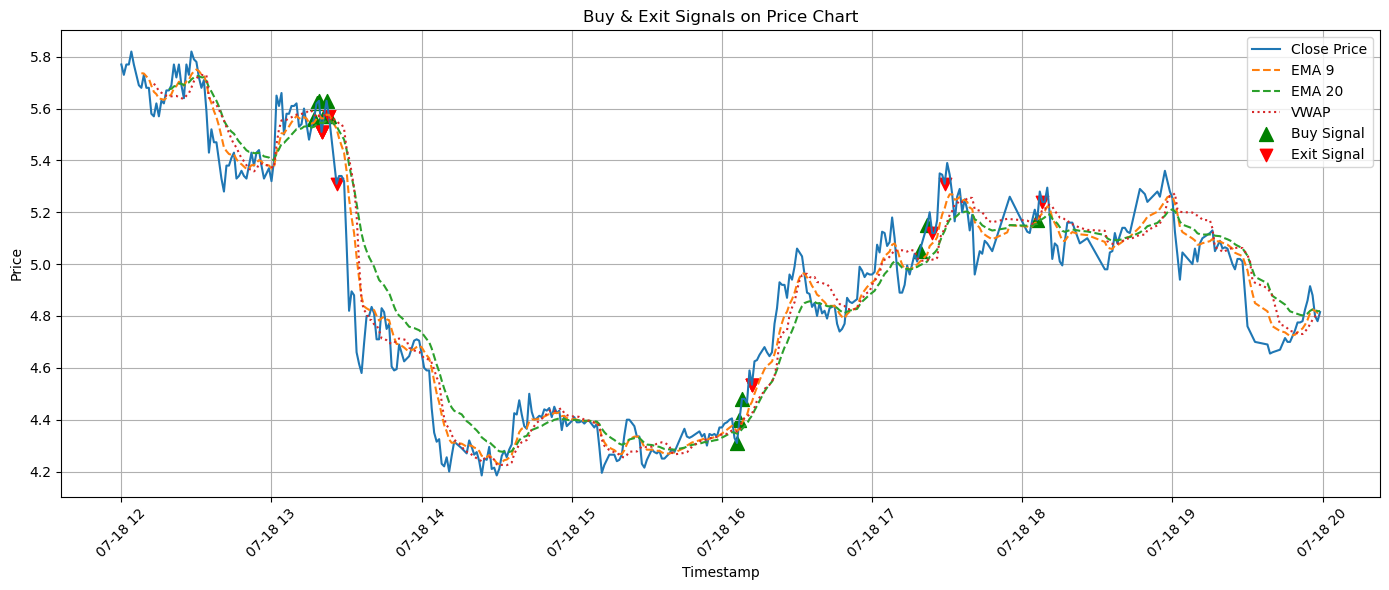

BZAI — Trades:
                   timestamp  entry   exit              outcome
0  2025-07-18 13:17:00+00:00   5.56  5.510            ema9_peak
1  2025-07-18 13:18:00+00:00   5.62  5.510            ema9_peak
2  2025-07-18 13:19:00+00:00   5.63  5.510       macd_flip_down
3  2025-07-18 13:21:00+00:00   5.57  5.570            ema9_peak
4  2025-07-18 13:22:00+00:00   5.63  5.570       macd_flip_down
5  2025-07-18 13:23:00+00:00   5.57  5.310          trend_break
6  2025-07-18 16:06:00+00:00   4.31  4.535  pullback_after_gain
7  2025-07-18 16:07:00+00:00   4.40  4.535  pullback_after_gain
8  2025-07-18 16:08:00+00:00   4.48  4.535  pullback_after_gain
9  2025-07-18 17:19:00+00:00   5.05  5.120  pullback_after_gain
10 2025-07-18 17:22:00+00:00   5.15  5.310  pullback_after_gain
11 2025-07-18 18:06:00+00:00   5.17  5.240  pullback_after_gain
Outcome counts:
 outcome
pullback_after_gain    6
ema9_peak              3
macd_flip_down         2
trend_break            1
Name: count, dtype: int64
Wi

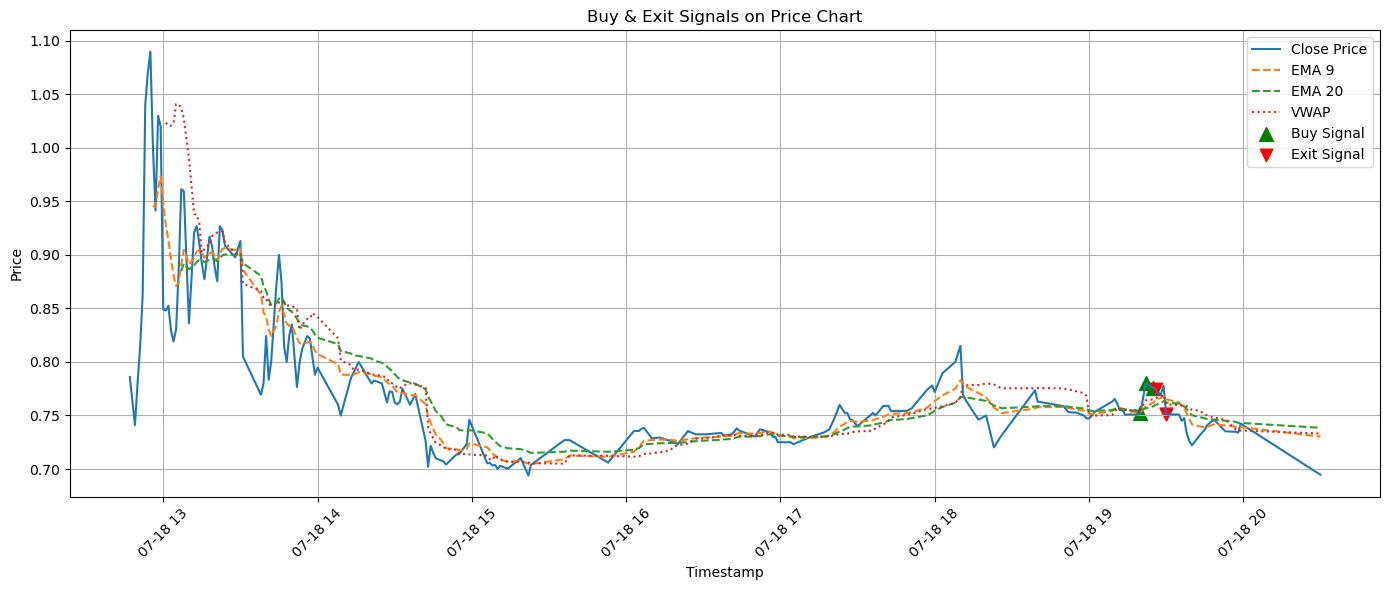

CPOP — Trades:
                  timestamp   entry    exit              outcome
0 2025-07-18 19:20:00+00:00  0.7523  0.7743  pullback_after_gain
1 2025-07-18 19:22:00+00:00  0.7800  0.7510            ema9_peak
2 2025-07-18 19:25:00+00:00  0.7760  0.7510            ema9_peak
Outcome counts:
 outcome
ema9_peak              2
pullback_after_gain    1
Name: count, dtype: int64
Win rate: 1/3 = 33.33%
Avg return per trade: -1.34%


🔍 Analyzing UAVS — Pre-market top gainer on 2025-07-18 …

UAVS — plotting buy & exit signals



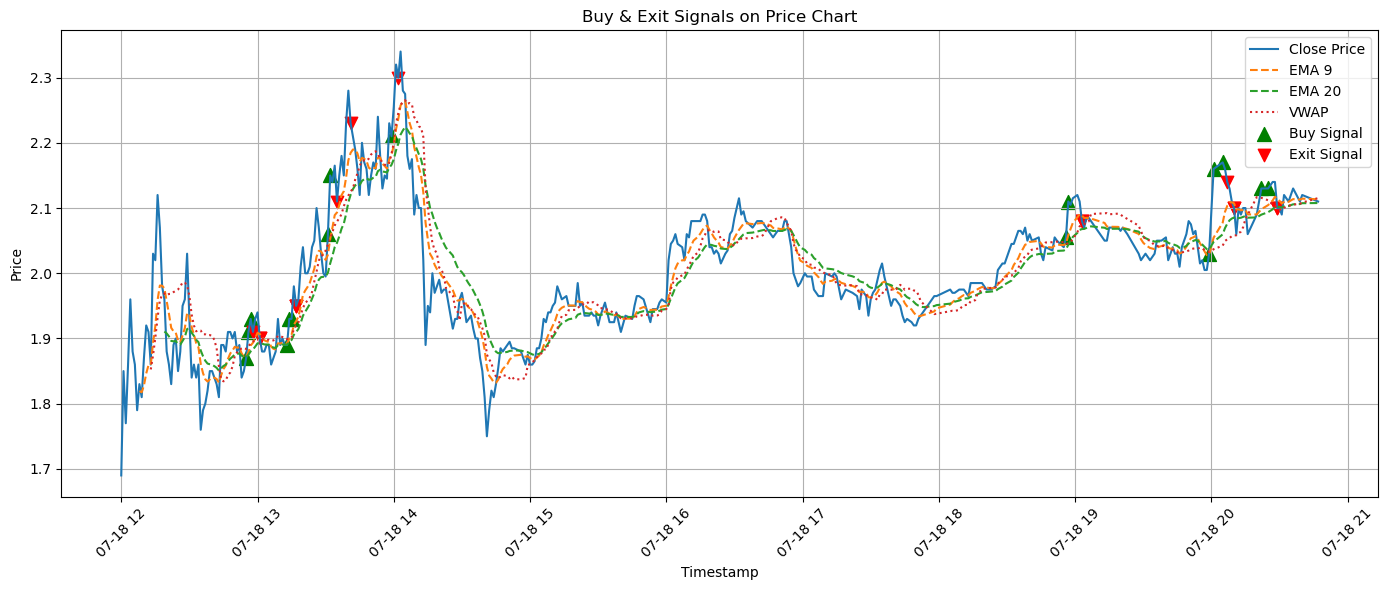

UAVS — Trades:
                   timestamp  entry  exit              outcome
0  2025-07-18 12:55:00+00:00  1.870  1.91  pullback_after_gain
1  2025-07-18 12:56:00+00:00  1.910  1.90            ema9_peak
2  2025-07-18 12:57:00+00:00  1.930  1.90            ema9_peak
3  2025-07-18 13:13:00+00:00  1.890  1.95  pullback_after_gain
4  2025-07-18 13:14:00+00:00  1.930  1.95  pullback_after_gain
5  2025-07-18 13:15:00+00:00  1.930  1.95  pullback_after_gain
6  2025-07-18 13:31:00+00:00  2.060  2.11  pullback_after_gain
7  2025-07-18 13:32:00+00:00  2.150  2.23  pullback_after_gain
8  2025-07-18 13:59:00+00:00  2.210  2.30  pullback_after_gain
9  2025-07-18 18:56:00+00:00  2.055  2.08  pullback_after_gain
10 2025-07-18 18:57:00+00:00  2.110  2.08            ema9_peak
11 2025-07-18 19:59:00+00:00  2.030  2.14  pullback_after_gain
12 2025-07-18 20:01:00+00:00  2.160  2.10            ema9_peak
13 2025-07-18 20:05:00+00:00  2.170  2.10            ema9_peak
14 2025-07-18 20:22:00+00:00  2.130  2.1

In [135]:
for t in ["BZAI", "CPOP", "UAVS"]:
    analyze_ticker_smart_plus(t, "2025-07-18", "2025-07-19")
